In [1]:
import os; os.chdir('D:/pyfops/')
import matplotlib.pyplot as plt
import jax.numpy as jnp, jax.random as random, jax.lax as lax

from src.core.forecasting.rough_bergomi.jax_rbergomi import g, b

In [2]:
# Define your parameters
N = 40000  # Number of paths
s = 365  # Time steps (365 in this case)
n = 365  # Length of convolution kernel
a = 0.5  # Roughness parameter
dW = random.normal(random.PRNGKey(0), (N, s, 2))  # Simulated Brownian increments

In [3]:
def Y(N, s, n, a, dW):
    """
    Constructs Volterra process from appropriately correlated 2d Brownian increments.
    """
    Y1 = jnp.zeros((N, 1 + s)) # Exact integrals
    def y1(i, Y1): # Construct Y1 through exact integral
        Y1 = Y1.at[:, i].set(dW[:, i-1, 1]) # Assuming kappa = 1
        return Y1
    
    Y1 = lax.fori_loop(1, 1 + s, y1, Y1)
    Y2 = jnp.zeros((N, 1 + s)) # Riemann sums

    # Construct arrays for convolution
    G = jnp.zeros(1 + s) # Gamma
    def pre_generate_array(k, G):
        G = G.at[k].set(g(b(k, a) / n, a))
        return G

    G = lax.fori_loop(2, 1 + s, pre_generate_array, G)
    X = dW[:, :, 0]  # Xi

    # Compute convolution, FFT not used for small n
    # Possible to compute for all paths in C-layer?
    GX = jnp.zeros((N, len(X[0,:]) + len(G) - 1))
    def convolve_row(i, GX):
        GX = GX.at[i,:].set(jnp.convolve(G, X[i, :]))
        return GX
    
    GX = lax.fori_loop(0, N, convolve_row, GX)

    # Extract appropriate part of convolution
    Y2 = GX[:, :1 + s]

    # Finally, construct and return the full process
    Y = jnp.sqrt(2 * a + 1) * (Y1 + Y2)
    return Y

In [4]:
def fft_convolve(G, X):
    # Zero-padding to the appropriate length for convolution
    G_padded = jnp.pad(G, (0, len(X) - 1))
    X_padded = jnp.pad(X, (0, len(G) - 1))

    # Perform FFT on both inputs
    G_fft = jnp.fft.fft(G_padded)
    X_fft = jnp.fft.fft(X_padded)

    # Element-wise multiplication in the Fourier domain
    result_fft = G_fft * X_fft

    # Inverse FFT to obtain the convolved result
    result = jnp.fft.ifft(result_fft)

    # Return the real part of the convolution
    return jnp.real(result[:len(X) + len(G) - 1])

def Y_fft(N, s, n, a, dW):
    """
    Constructs Volterra process from appropriately correlated 2D Brownian increments.
    Parameters:
    - N: number of paths
    - s: steps in time
    - n: convolution kernel length (typically 365 in your case)
    - a: roughness parameter
    - dW: Brownian increments
    - use_fft: If True, uses FFT-based convolution, else direct convolution
    """
    Y1 = jnp.zeros((N, 1 + s))  # Exact integrals
    def y1(i, Y1):  # Construct Y1 through exact integral
        Y1 = Y1.at[:, i].set(dW[:, i - 1, 1])  # Assuming kappa = 1
        return Y1
    
    Y1 = lax.fori_loop(1, 1 + s, y1, Y1)
    
    Y2 = jnp.zeros((N, 1 + s))  # Riemann sums

    # Construct arrays for convolution
    G = jnp.zeros(1 + s)  # Gamma array
    def pre_generate_array(k, G):
        G = G.at[k].set(g(b(k, a) / n, a))
        return G

    G = lax.fori_loop(2, 1 + s, pre_generate_array, G)
    X = dW[:, :, 0]  # Xi from the Brownian increments

    # Compute convolution: option to use FFT-based or direct convolution
    GX = jnp.zeros((N, len(X[0, :]) + len(G) - 1))
    
    def convolve_row_fft(i, GX):
        GX = GX.at[i, :].set(fft_convolve(G, X[i, :]))
        return GX
    GX = lax.fori_loop(0, N, convolve_row_fft, GX)

    # Extract appropriate part of convolution
    Y2 = GX[:, :1 + s]

    # Finally, construct and return the full process
    Y = jnp.sqrt(2 * a + 1) * (Y1 + Y2)
    return Y

Time taken for direct convolution: 0.576588 seconds
Time taken for FFT-based convolution: 0.224001 seconds
[ 0.00000000e+00 -1.15018892e+00  6.21431947e-01 -2.24528718e+00
  7.64710724e-01 -1.36322904e+00  5.76248169e-01  1.64463222e+00
 -3.90987873e-01 -1.91210186e+00  1.19930983e+00 -2.26014495e+00
 -1.39057207e+00  1.86510527e+00  1.56320167e+00 -9.28997755e-01
  3.83987337e-01 -1.02735102e+00 -1.90713036e+00  1.40964180e-01
  9.07804608e-01  1.40423894e+00 -6.24126531e-02 -1.48723817e+00
 -1.72059107e+00 -2.99168348e-01 -2.19370484e+00 -2.83934045e+00
 -2.07052827e+00 -2.61883354e+00 -4.38364363e+00 -2.40287399e+00
 -3.37629628e+00 -1.57874501e+00  6.11781739e-02 -2.46942067e+00
 -1.04273474e+00 -5.32388115e+00 -1.88060284e+00 -2.36978745e+00
 -4.65753269e+00 -2.38448620e+00 -2.05021143e+00 -4.10388660e+00
 -1.64538109e+00 -3.16735148e+00 -1.82095242e+00 -4.87613726e+00
 -2.40220547e+00 -2.00284362e+00 -3.97862124e+00 -6.43802452e+00
 -3.48416924e+00 -3.71185064e+00 -4.04932070e+00

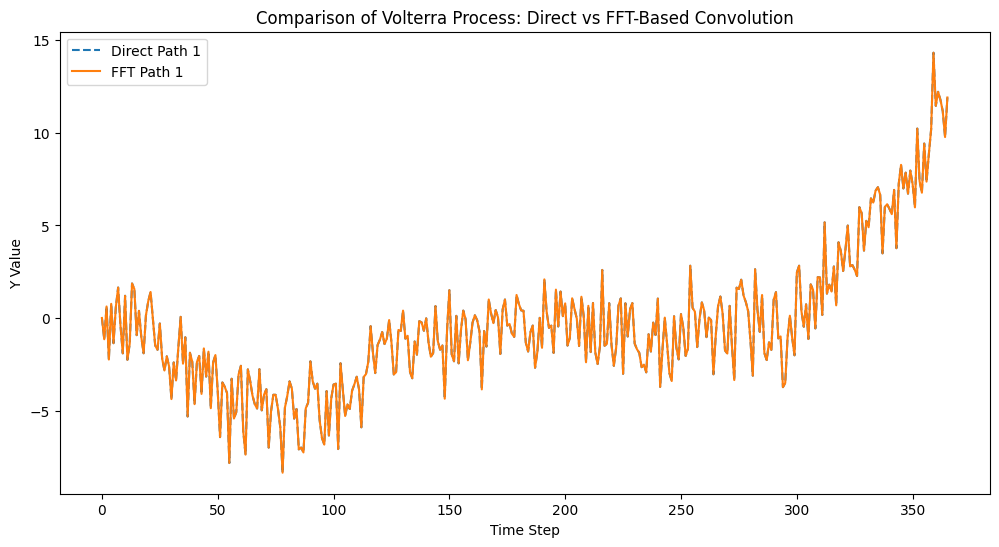

In [5]:
import time; t1 = time.time()
# Compute Y using direct convolution
Y_direct = Y(N, s, n, a, dW)
print(f"Time taken for direct convolution: {time.time() - t1:.6f} seconds"); t2 = time.time()
# Compute Y using FFT-based convolution
Y_fft = Y_fft(N, s, n, a, dW)
print(f"Time taken for FFT-based convolution: {time.time() - t2:.6f} seconds")
print(Y_direct[0, :], Y_fft[0, :], jnp.abs(Y_direct[0, :] - Y_fft[0, :]), sep='\n')

# Plot the first few paths to compare results
plt.figure(figsize=(12, 6))

for i in range(1):  # Plotting 5 paths for comparison
    plt.plot(Y_direct[i, :], label=f"Direct Path {i+1}", linestyle='--')
    plt.plot(Y_fft[i, :], label=f"FFT Path {i+1}", linestyle='-')

plt.title("Comparison of Volterra Process: Direct vs FFT-Based Convolution")
plt.xlabel("Time Step")
plt.ylabel("Y Value")
plt.legend()
plt.show()